<a href="https://colab.research.google.com/github/mkosaka1/capstone_project/blob/master/eda_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ls

drive/  sample_data/


# Single file

In [ ]:
import librosa
x, sr = librosa.load('/content/drive/My Drive/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
import librosa
x, sr = librosa.load('/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
print(x.shape)
print(sr)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [ ]:
from IPython.display import Audio

In [ ]:
Audio(data=x, rate=sr)

In [ ]:
single_mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(single_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
single_mfcc

# Whole Dataset (1440 files)

In [169]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split



Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

Video-only (02)

Speech (01)

Fearful (06)

Normal intensity (01)

Statement "dogs" (02)

1st Repetition (01)

12th Actor (12) - Female (as the actor ID number is even)

In [170]:
audio = "/content/drive/My Drive/audio/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['1', 'Actor_01', 'Actor_02', 'Actor_03', 'Actor_04']

In [ ]:
audio = "/Users/murielkosaka/Desktop/capstone_project/audio/audio_speech_actors_01-24/"

actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

In [ ]:
audio

In [171]:
# audio/audio/audio_speech_actors_01-24/Actor_14
# 03-01-02-01-02-01-14.wav

emotion = []
gender = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [172]:
os.listdir(audio + i)

['03-01-06-01-02-02-24.wav',
 '03-01-04-01-02-02-24.wav',
 '03-01-03-02-02-01-24.wav',
 '03-01-06-01-02-01-24.wav',
 '03-01-04-01-01-02-24.wav',
 '03-01-05-02-02-02-24.wav',
 '03-01-04-02-02-01-24.wav',
 '03-01-01-01-01-02-24.wav',
 '03-01-05-02-01-01-24.wav',
 '03-01-06-02-02-01-24.wav',
 '03-01-04-01-01-01-24.wav',
 '03-01-01-01-01-01-24.wav',
 '03-01-05-01-02-02-24.wav',
 '03-01-02-01-02-02-24.wav',
 '03-01-02-02-01-02-24.wav',
 '03-01-07-01-02-01-24.wav',
 '03-01-06-01-01-01-24.wav',
 '03-01-03-01-01-02-24.wav',
 '03-01-03-01-01-01-24.wav',
 '03-01-04-01-02-01-24.wav',
 '03-01-07-01-01-01-24.wav',
 '03-01-06-01-01-02-24.wav',
 '03-01-02-02-01-01-24.wav',
 '03-01-02-01-02-01-24.wav',
 '03-01-05-02-02-01-24.wav',
 '03-01-04-02-01-01-24.wav',
 '03-01-05-01-01-02-24.wav',
 '03-01-04-02-01-02-24.wav',
 '03-01-03-02-02-02-24.wav',
 '03-01-04-02-02-02-24.wav',
 '03-01-03-02-01-02-24.wav',
 '03-01-05-01-01-01-24.wav',
 '03-01-06-02-01-02-24.wav',
 '03-01-02-02-02-02-24.wav',
 '03-01-01-01-

In [173]:
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df
audio_df = pd.concat([pd.DataFrame(gender),audio_df],axis=1)
audio_df.columns = ['gender','emotion']
# audio_df['labels'] =audio_df.gender + '_' + audio_df.emotion
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
# audio_df = audio_df.drop(['gender', 'emotion'], axis=1)
# audio_df.labels.value_counts()
audio_df

# GENDER + EMOTION
# audio_df = pd.DataFrame(emotion)
# audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
# audio_df = pd.concat([pd.DataFrame(gender),audio_df],axis=1)
# audio_df.columns = ['gender','emotion']
# audio_df['labels'] =audio_df.gender + '_' + audio_df.emotion
# audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
# audio_df = audio_df.drop(['gender', 'emotion'], axis=1)
# audio_df.labels.value_counts()

,gender,emotion,path
0,male,fear,/content/drive/My Drive/audio/audio_speech_act...
1,male,neutral,/content/drive/My Drive/audio/audio_speech_act...
2,male,happy,/content/drive/My Drive/audio/audio_speech_act...
3,male,happy,/content/drive/My Drive/audio/audio_speech_act...
4,male,calm,/content/drive/My Drive/audio/audio_speech_act...
...,...,...,...
1435,female,surprise,/content/drive/My Drive/audio/audio_speech_act...
1436,female,disgust,/content/drive/My Drive/audio/audio_speech_act...
1437,female,surprise,/content/drive/My Drive/audio/audio_speech_act...
1438,female,surprise,/content/drive/My Drive/audio/audio_speech_act...


In [174]:
audio_df.to_csv('audio.csv')

In [ ]:

os.listdir(audio)

In [ ]:
fname = audio + 'Actor_02/03-01-01-01-01-01-02.wav'  #female neutral
data_neutral, sr_neutral = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data_neutral, sr=sr_neutral)
ipd.Audio(fname)

In [ ]:
fname = audio + 'Actor_02/03-01-02-01-01-01-02.wav'  #female calm
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)
ipd.Audio(fname)


# MFCC
### The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. MFCC is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth

In [ ]:
fa_mfcc = librosa.feature.mfcc(y=data_neutral, sr=sr_neutral, n_mfcc=13)
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(fa_mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [ ]:
# MFCC
#The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features 
#(usually about 10–20) which concisely describe the overall shape of a spectral envelope.
# good "representation" of the vocal tract that produces the sound. Think of it like an 
# x-ray of your mouth
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13)

plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar();

In [ ]:
mfcc.shape

216
216
216
216


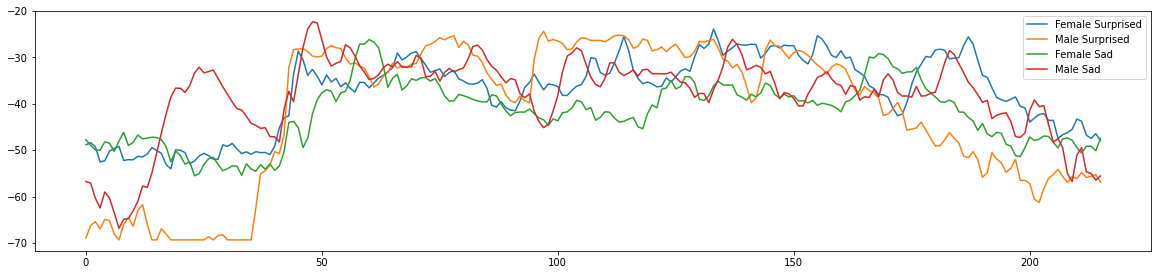

In [9]:
# Male surprised
pathh = audio + 'Actor_09/03-01-08-02-02-02-09.wav'
X, sample_rate = librosa.load(pathh, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Female surprised
path= audio + 'Actor_08/03-01-08-02-02-02-08.wav'
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Male sad
pathh = audio + 'Actor_09/03-01-04-02-02-02-09.wav'
X, sample_rate = librosa.load(pathh, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male1 = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male1 = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male1))

# Female sad
path= audio + 'Actor_08/03-01-04-02-02-02-08.wav'
X, sample_rate = librosa.load(path,duration=2.5,sr=22050*2,offset=0.5)
female1 = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female1 = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female1))

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='Female Surprised')
plt.plot(male, label='Male Surprised')
plt.plot(female1, label='Female Sad')
plt.plot(male1, label='Male Sad')
plt.legend()



In [ ]:
# Spectrogram - how the audio spectrum varies as a function of time
spectrogram = librosa.feature.melspectrogram(y=X, sr=sampling_rate)
db_spec = librosa.power_to_db(spectrogram, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='time', sr=sampling_rate)
plt.colorbar();

## Feature Extraction

In [7]:
df = pd.DataFrame(columns=['mfcc_feature','spec_feat','chroma_feat'])

counter=0

for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=0)

    
    #get the mel-scaled spectrogram ()
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 0)
    
    #compute chroma energy (pertains to 12 different pitch classes)
    chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 0)
    
    # #compute spectral contrast
    # contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
    # contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
    # which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
    # zcr = librosa.feature.zero_crossing_rate(y=X)
    # zcr = np.mean(zcr, axis= 0)
    
    df.loc[counter] = [mfcc,spectrogram,chroma]
    counter=counter+1   

print(len(df))
df.head()

1440


,mfcc_feature,spec_feat,chroma_feat
0,"[-63.52352959684379, -63.52352959684379, -63.5...","[2.440053844431309e-09, 2.478540403723405e-09,...","[0.7427262094246531, 0.8283234352310781, 0.861..."
1,"[-65.8009712673087, -65.8009712673087, -65.800...","[4.668650934874186e-13, 2.1799963776074315e-11...","[0.8890836152031082, 0.9509049090189307, 0.942..."
2,"[-58.73100684143704, -58.74653122015798, -58.0...","[5.6260320075150826e-08, 4.473663025456934e-08...","[0.5870218278924267, 0.6308990925004826, 0.589..."
3,"[-65.24334603230012, -65.24334603230012, -65.2...","[9.286164115495421e-10, 5.020287711232715e-10,...","[0.8123938350303129, 0.7807005290454773, 0.837..."
4,"[-67.55739512198222, -67.55739512198222, -67.5...","[5.110802400824844e-12, 7.360911965012259e-10,...","[0.6135061143057753, 0.615762566340163, 0.6201..."


In [48]:
print (mfcc.mean(axis=1))
print (mfcc.var(axis=1))

IndexError: ignored

In [28]:
df.columns

Index(['mfcc_feature', 'spec_feat', 'chroma_feat', 'contrast_feat'], dtype='object')

In [6]:
df = pd.DataFrame(columns=['mfcc_feature'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   


print(len(df))
df.head()


1440


,mfcc_feature
0,"[-63.52352959684379, -63.52352959684379, -63.5..."
1,"[-65.8009712673087, -65.8009712673087, -65.800..."
2,"[-58.73100684143704, -58.74653122015798, -58.0..."
3,"[-65.24334603230012, -65.24334603230012, -65.2..."
4,"[-67.55739512198222, -67.55739512198222, -67.5..."


In [ ]:
df_chroma = pd.DataFrame(columns=['chroma_feat'])

# feature extraction over the entire dataset
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)
    sample_rate = np.array(sample_rate)
    
    chroma=np.mean(librosa.feature.chroma_stft(X, sr=sample_rate).T,axis=0)
    df_chroma.loc[counter] = [chroma]
    counter=counter+1   


print(len(df_chroma))
df_chroma.head()

In [ ]:
# rmse = librosa.feature.rmse(y=y)
# spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) : DO NOT USE - INDICATES WHERE CENTER OF MASS IS, IS THE SAME FOR HAPPY AND SURPRISED
# spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
# rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
# zcr = librosa.feature.zero_crossing_rate(y)

## CNN

In [201]:
# Extract the mean bands to its own feature columns
df_combined = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist()),
                         pd.DataFrame(df['chroma_feat'].values.tolist()),
                         pd.DataFrame(df['spec_feat'].values.tolist())
                         ],axis=1)
df_combined = df_combined.fillna(0)

KeyError: ignored

In [9]:
df_combined.drop(columns='gender',inplace=True)

In [10]:
df_combined.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,9.470058e-06,2.578390e-05,2.461057e-05,1.202463e-05,5.154764e-06,2.293928e-06,8.568837e-07,1.537127e-06,2.078454e-06,2.184434e-06,3.041122e-06,1.803422e-06,1.143403e-06,7.627434e-07,3.888000e-07,1.779640e-07,1.923068e-07,3.168509e-07,2.245657e-07,2.101146e-07,1.500544e-07,1.671772e-07,1.471501e-07,1.313681e-07,8.375042e-08,3.572479e-08,2.370430e-08,3.129491e-08,2.816052e-08,2.174507e-08,2.531549e-08,1.924894e-08,1.741787e-08,1.225668e-08,7.529888e-09,5.454092e-09,6.819510e-09,1.796941e-08,1.751192e-08,7.574554e-09
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,3.132524e-09,2.293366e-09,1.289942e-09,3.135538e-09,4.808926e-09,9.926860e-09,4.514360e-09,3.569078e-10,3.039941e-10,4.092756e-10,2.502424e-10,8.785423e-11,4.097390e-10,3.496092e-10,8.525146e-11,9.268422e-11,2.479107e-11,1.047995e-10,6.573235e-10,1.409621e-09,3.839809e-10,9.462552e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,2.422831e-07,1.714550e-07,1.098402e-07,1.919263e-07,2.688476e-07,1.465773e-07,1.096860e-07,9.550388e-08,1.298970e-07,1.184836e-07,1.274261e-07,2.088348e-07,1.981786e-07,1.049217e-07,5.793580e-08,7.813114e-08,8.910524e-08,3.787632e-08,4.967923e-08,5.793108e-08,2.227009e-08,2.370553e-08,2.333633e-08,1.691262e-08,1.855947e-08,2.228112e-08,1.963106e-08,1.471574e-08,2.673383e-08,2.712630e-08,1.231842e-08,7.812410e-09,7.712507e-10,7.638044e-10,1.757530e-09,2.919100e-09,8.747867e-10,4.573883e-10,5.310010e-10,7.820663e-11
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,1.324463e-07,1.342138e-07,2.391723e-07,1.658444e-07,1.556888e-07,1.030683e-07,1.267966e-07,1.693123e-07,1.926444e-07,1.948504e-07,5.296063e-08,3.158196e-08,5.809344e-08,1.287589e-07,1.516797e-07,2.053868e-07,4.422756e-07,3.753533e-07,2.2

In [32]:
# Extract the mean bands to its own feature columns
df = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist())],axis=1)
df=df.fillna(0)

In [12]:
df_combined.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,9.470058e-06,2.578390e-05,2.461057e-05,1.202463e-05,5.154764e-06,2.293928e-06,8.568837e-07,1.537127e-06,2.078454e-06,2.184434e-06,3.041122e-06,1.803422e-06,1.143403e-06,7.627434e-07,3.888000e-07,1.779640e-07,1.923068e-07,3.168509e-07,2.245657e-07,2.101146e-07,1.500544e-07,1.671772e-07,1.471501e-07,1.313681e-07,8.375042e-08,3.572479e-08,2.370430e-08,3.129491e-08,2.816052e-08,2.174507e-08,2.531549e-08,1.924894e-08,1.741787e-08,1.225668e-08,7.529888e-09,5.454092e-09,6.819510e-09,1.796941e-08,1.751192e-08,7.574554e-09
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,3.132524e-09,2.293366e-09,1.289942e-09,3.135538e-09,4.808926e-09,9.926860e-09,4.514360e-09,3.569078e-10,3.039941e-10,4.092756e-10,2.502424e-10,8.785423e-11,4.097390e-10,3.496092e-10,8.525146e-11,9.268422e-11,2.479107e-11,1.047995e-10,6.573235e-10,1.409621e-09,3.839809e-10,9.462552e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,2.422831e-07,1.714550e-07,1.098402e-07,1.919263e-07,2.688476e-07,1.465773e-07,1.096860e-07,9.550388e-08,1.298970e-07,1.184836e-07,1.274261e-07,2.088348e-07,1.981786e-07,1.049217e-07,5.793580e-08,7.813114e-08,8.910524e-08,3.787632e-08,4.967923e-08,5.793108e-08,2.227009e-08,2.370553e-08,2.333633e-08,1.691262e-08,1.855947e-08,2.228112e-08,1.963106e-08,1.471574e-08,2.673383e-08,2.712630e-08,1.231842e-08,7.812410e-09,7.712507e-10,7.638044e-10,1.757530e-09,2.919100e-09,8.747867e-10,4.573883e-10,5.310010e-10,7.820663e-11
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,1.324463e-07,1.342138e-07,2.391723e-07,1.658444e-07,1.556888e-07,1.030683e-07,1.267966e-07,1.693123e-07,1.926444e-07,1.948504e-07,5.296063e-08,3.158196e-08,5.809344e-08,1.287589e-07,1.516797e-07,2.053868e-07,4.422756e-07,3.753533e-07,2.2

In [202]:
from sklearn.model_selection import train_test_split

# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df_combined.drop(['path','emotion'],axis=1), 
                                                    df_combined.emotion
                                                    , test_size=0.25
                                                    , shuffle=False
                                                    , random_state=42
                                                   )


# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
150,-44.634383,-44.699532,-44.712666,-44.634940,-44.523817,-44.407850,-44.553968,-44.552648,-44.371251,-44.258457,-44.109070,-44.085618,-44.166747,-43.320216,-42.447113,-41.283145,-41.300251,-41.407126,-41.307588,-41.425060,-41.358621,-40.892776,-41.650727,-42.140213,-41.099520,-39.753972,-40.046897,-40.654586,-39.941824,-36.609685,-34.835364,-36.525836,-38.466208,-35.032988,-33.522536,-37.165264,-40.285436,-40.216115,-36.447744,-34.439681,...,0.020949,0.009223,0.009553,0.005296,0.002909,0.004915,0.027826,0.366756,6.337535,22.534066,16.039871,8.203422,5.772537,6.588116e+00,8.421876e+00,9.347421e+00,8.185054e+00,6.422848,8.630803,1.066743e+01,8.790093,7.020253,6.388901,9.639234,17.667800,18.321511,10.085772,8.734394,6.433994,3.878870,4.961278,5.919205,4.958098,4.185065,3.945929,4.344380,5.192151,5.006805e+00,4.888036e+00,5.290379e+00
151,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-57.703591,-55.243611,-43.579833,-37.644674,-34.605452,-34.057393,-39.193650,-42.836508,...,0.000006,0.000007,0.000006,0.000004,0.000005,0.000005,0.000006,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,7.494819e-07,3.631498e-07,2.690470e-07,2.365355e-07,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
152,-65.610482,-64.996448,-62.692419,-61.768702,-62.095405,-62.928018,-65.443917,-64.495961,-61.916573,-59.725198,-59.451859,-61.952607,-59.987793,-60.209356,-61.292740,-60.706901,-59.035828,-60.119599,-60.442570,-61.598265,-63.100345,-62.953895,-61.963831,-61.387804,-60.073442,-61.306968,-62.791729,-63.273428,-64.317219,-64.104521,-64.884901,-65.661109,-65.686413,-64.947971,-63.417423,-61.902988,-61.103455,-58.470841,-59.941510,-62.750994,...,0.000015,0.000011,0.000007,0.000022,0.000041,0.000026,0.000021,0.000011,0.000005,0.000002,0.000002,0.000002,0.000002,1.728957e-06,9.738791e-07,7.026525e-07,1.054836e-06,0.000002,0.000002,9.996905e-07,0.000001,0.000002,0.000002,0.000002,0.000003,0.000003,0.000002,0.000003,0.000003,0.000004,0.000003,0.000003,0.000005,0.000005,0.000003,0.000003,0.000005,5.980607e-06,6.534032e-06,5.780020e-06
153,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-59.402149,-60.016699,-60.897846,-60.566259,-59.310135,-57.990380,-57.457525,-58.447179,-58.908676,-59.194884,-59.069550,-58.758886,-58.886182,-58.599524,...,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000002,0.000003,0.000004,0.000004,0.000003,0.000002,0.000003,3.153294e-06,2.397970e-06,1.928619e-06,1.748814e-06,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
154,-41.068665,-41.513452,-41.918814,-42.079815,-41.785034,-41.377093,-40.835283,-41.420680,-40.971840,-41.009717,-41.798195,-41.817994,-41.507800,-41.370318,-41.440510,-41.455024,-41.753007,-41.441369,-41.945558,-42.320771,-41.963835,-41.405240,-40.994574,-41.187947,-41.699031,-41.892630,-41.761722,-41.207147,-41.415160,-41.701201,-41.629518,-40.962919,-41.

In [21]:
df_combined[df_combined.index.duplicated()]



,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258


In [200]:
#Data normalization 
X_train = np.array(X_train) / 255
X_validation = np.array(X_validation) / 255
X_test = np.array(X_test) / 255

array([[ 0.00000000e+00],
       [ 1.31581988e-17],
       [ 1.31581988e-17],
       [-1.31581988e-17],
       [ 0.00000000e+00],
       [ 2.63163976e-17],
       [ 0.00000000e+00],
       [-1.31581988e-17],
       [-1.31581988e-17],
       [-1.31581988e-17],
       [ 1.31581988e-17],
       [ 1.31581988e-17],
       [-1.31581988e-17],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-1.31581988e-17],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.31581988e-17],
       [-1.31581988e-17],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.31581988e-17],
       [-1.31581988e-17],
       [-1.31581988e-17],
       [ 0.00000000e+00],
       [-1.31581988e-17],
       [-1.31581988e-17],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.31581988e-17],
       [ 0.00000000e+00],
       [-1.31581988e-17],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-1.31581988e-17],
       [ 1.3

In [36]:
len(X_train)

1080

In [38]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [39]:
y_test

array(['calm', 'happy', 'neutral', 'happy', 'calm', 'happy', 'calm',
       'neutral', 'calm', 'calm', 'happy', 'happy', 'happy', 'calm',
       'calm', 'calm', 'neutral', 'sad', 'happy', 'neutral', 'happy',
       'disgust', 'sad', 'surprise', 'angry', 'angry', 'fear', 'disgust',
       'fear', 'disgust', 'angry', 'angry', 'disgust', 'fear', 'surprise',
       'surprise', 'disgust', 'disgust', 'surprise', 'sad', 'sad',
       'surprise', 'fear', 'sad', 'angry', 'sad', 'surprise', 'fear',
       'disgust', 'fear', 'surprise', 'angry', 'fear', 'fear', 'disgust',
       'surprise', 'angry', 'sad', 'sad', 'angry', 'neutral', 'neutral',
       'calm', 'calm', 'calm', 'happy', 'neutral', 'calm', 'calm', 'calm',
       'calm', 'calm', 'neutral', 'happy', 'disgust', 'fear', 'surprise',
       'fear', 'disgust', 'sad', 'sad', 'happy', 'angry', 'disgust',
       'happy', 'sad', 'fear', 'happy', 'angry', 'angry', 'angry', 'fear',
       'surprise', 'happy', 'sad', 'fear', 'surprise', 'surprise',

In [26]:
len(y_train)

1080

In [40]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical

# # one hot encode the target 
# CNN requires input and output are numbers
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = lb.fit_transform(y_test)
y_test = to_categorical(y_test)
print(y_train[0:10])


# lb = LabelEncoder()
# y_train = to_categorical(lb.fit_transform(y_train))
# y_test = to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])

# # # one hot encode the target 
# lb = LabelEncoder()
# y_train = np_utils.to_categorical(lb.fit_transform(y_train))
# y_test = np_utils.to_categorical(lb.fit_transform(y_test))
# print(y_train[0:10])



[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]


In [41]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [42]:
#time series data requires kernel sliding in only one dimension and have spatial properties
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape

# X_train = np.expand_dims(X_train, axis=2)
# X_test = np.expand_dims(X_test, axis=2)
# X_train.shape

(1080, 777, 1)

In [43]:
y_train.shape

(1080, 8)

In [44]:
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM

model = Sequential()
model.add(Conv1D(32, kernel_size=(3), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))
model.add(Conv1D(64, kernel_size=(3), activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))
model.add(Conv1D(128, kernel_size=(3), activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.25))
model.add(Conv1D(128, kernel_size=(3), activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = keras.optimizers.Adam(lr=0.0001)




# New model
# model = Sequential()
# model.add(Conv1D(32, 5, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(64, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(64, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(256, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Conv1D(256, 5, activation='relu'))
# model.add(Dropout(0.25))
# model.add(MaxPooling1D(pool_size=(4)))
# model.add(Flatten())
# model.add(Dense(16)) # Target class number
# model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
# opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
# model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 775, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 773, 64)           6208      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 386, 64)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 386, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 384, 64)           12352     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 192, 64)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 192, 64)          

In [45]:
batch_size=1
epochs=50

In [46]:
# categorical crossentropy since output variable has more than 2 label classes
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/50
1080/1080 [==============================] - 17s 16ms/step - loss: 1.9179 - accuracy: 0.2407 - val_loss: 1.8934 - val_accuracy: 0.2583
Epoch 2/50
1080/1080 [==============================] - 17s 15ms/step - loss: 1.7291 - accuracy: 0.3269 - val_loss: 1.8042 - val_accuracy: 0.3111
Epoch 3/50
1080/1080 [==============================] - 16s 15ms/step - loss: 1.6085 - accuracy: 0.3963 - val_loss: 1.7828 - val_accuracy: 0.3333
Epoch 4/50
1080/1080 [==============================] - 16s 15ms/step - loss: 1.5720 - accuracy: 0.4037 - val_loss: 1.7562 - val_accuracy: 0.3833
Epoch 5/50
1080/1080 [==============================] - 17s 16ms/step - loss: 1.5059 - accuracy: 0.4148 - val_loss: 1.7434 - val_accuracy: 0.3806
Epoch 6/50
1080/1080 [==============================] - 17s 16ms/step - loss: 1.4583 - accuracy: 0.4398 - val_loss: 1.7839 - val_accuracy: 0.3528
Epoch 7/50
1080/1080 [==============================] - 17s 16ms/step - loss: 1.3910 - accuracy: 0.4833 - val_loss: 1.7895 -

In [47]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

12/12 [==============================] - 0s 38ms/step - loss: 5.7833 - accuracy: 0.3806
Loss of the model is -  5.78333044052124
12/12 [==============================] - 0s 37ms/step - loss: 5.7833 - accuracy: 0.3806
Accuracy of the model is -  38.05555701255798 %


In [ ]:
model, test_acc = evaluate_model(X_train, X_val, y_train, y_val)
print('>%.3f' % val_acc)
cv_scores.append(val_acc)
model_history.append(model)

print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))


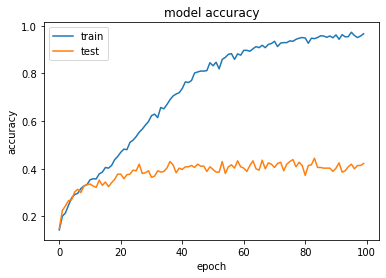

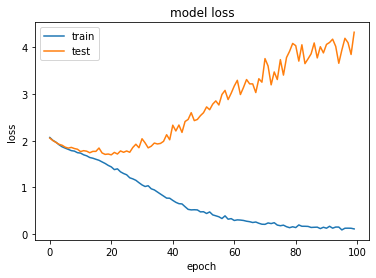

In [76]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [160]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score



In [161]:
def make_classifier():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=(3), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Conv1D(64, kernel_size=(3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(Conv1D(64, kernel_size=(3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=(3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=(3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))   
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return classifier

In [162]:
classifier = KerasClassifier(build_fn = make_classifier,
                            batch_size=10, nb_epoch=100)


In [163]:
accuracies = cross_val_score(estimator = classifier,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             n_jobs = -1)

In [164]:
mean = accuracies.mean()


In [165]:
variance = accuracies.var()


In [167]:
classifier.fit(X_train,y_train)

AttributeError: ignored

In [135]:
from sklearn.model_selection import GridSearchCV
def make_classifier(optimizer):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=(3), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Conv1D(64, kernel_size=(3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(Conv1D(64, kernel_size=(3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=(3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=(3), activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))   
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return classifier


In [149]:
classifier = KerasClassifier(build_fn = make_classifier)


In [150]:
params = {
    'batch_size':[20,35],
    'nb_epoch':[150,500],
    'optimizer':['adam','rmsprop']
}

In [151]:
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=10)

In [153]:
grid_search = grid_search.fit(X_train,y_train)




TypeError: ignored

In [ ]:
best_param = grid_search.best_params_
best_accuracy = grid_search.best_score_


In [ ]:
#100 epoch
# accuracy: .8620, 38.88
# 0.7935, loss:1.88, 41.94

In [ ]:
# 50 epoch
# val_accuracy = .3972 mfcc
      # .3722 mfcc
# val_accuracy = 0.2139 chroma
# val_accuracy = 0.0639 mfcc + chroma
# 50 epoch - changed random_state
# val_accuracy

In [ ]:
# def extract_feature(file_name, mfcc, chroma, mel):
#     with soundfile.SoundFile(file_name) as sound_file:
#         X = sound_file.read(dtype="float32")
#         sample_rate=sound_file.samplerate
#         if chroma:
#             stft=np.abs(librosa.stft(X))
#         result=np.array([])
#         if mfcc:
#             mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
#             result=np.hstack((result, mfccs))
#         if chroma:
#             chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, chroma))
#         if mel:
#             mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
#             result=np.hstack((result, mel))

DATA AUGMENTATION

In [180]:
pre_aug= pd.read_csv('audio.csv',usecols=['emotion','path'])
pre_aug.head()

,emotion,path
0,fear,/content/drive/My Drive/audio/audio_speech_act...
1,neutral,/content/drive/My Drive/audio/audio_speech_act...
2,happy,/content/drive/My Drive/audio/audio_speech_act...
3,happy,/content/drive/My Drive/audio/audio_speech_act...
4,calm,/content/drive/My Drive/audio/audio_speech_act...


In [182]:
from tqdm import tqdm


In [186]:
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [188]:
df1 = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(pre_aug.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df1.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df1.head()

100%|██████████| 1440/1440 [10:56<00:00,  2.19it/s]


,feature
0,"[-63.52352959684379, -63.52352959684379, -63.5..."
1,"[-65.8009712673087, -65.8009712673087, -65.800..."
2,"[-58.73100684143704, -58.74653122015798, -58.0..."
3,"[-65.24334603230012, -65.24334603230012, -65.2..."
4,"[-67.55739512198222, -67.55739512198222, -67.5..."


In [199]:
df.head()

,emotion,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,fear,/content/drive/My Drive/audio/audio_speech_act...,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.377373,-61.595853,-63.160227,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.523530,-63.486761,-63.453534,-60.923158,-58.164801,-58.033787,-57.377220,-58.619264,-57.489921,-57.051144,-58.815463,-59.090078,-58.199690,-57.456970,-53.362825,-48.075103,...,-29.173452,-30.587588,-29.460077,-29.089244,-28.431386,-27.486497,-25.458800,-23.080926,-21.972054,-21.471052,-23.320959,-26.888781,-28.113588,-27.575900,-28.785640,-32.255878,-35.242089,-35.369591,-36.281778,-39.144354,-39.930927,-39.638008,-40.616663,-40.774148,-40.808047,-43.076379,-40.145070,-39.692720,-39.173858,-41.141976,-39.336517,-39.847823,-40.466040,-40.448086,-42.883065,-43.367558,-46.280296,-48.273818,-49.745182,-50.472916
1,neutral,/content/drive/My Drive/audio/audio_speech_act...,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.800971,-65.793168,-65.800971,-65.800971,-65.800971,-63.896145,-60.063347,-61.391446,-59.506572,-61.304348,-60.479436,-59.622011,-59.312969,-56.807714,-57.467487,-54.780278,-54.338120,-56.671499,-56.021689,-55.159339,-55.876813,-56.127683,-56.435845,...,-59.615328,-56.169903,-57.875562,-61.149496,-62.058126,-58.724914,-56.277627,-58.083108,-60.733636,-62.754215,-63.549244,-64.526266,-65.800971,-65.771172,-62.390423,-60.171205,-61.831569,-64.845866,-64.133097,-63.383669,-61.310815,-60.995465,-62.350353,-62.845241,-60.302466,-58.946521,-59.711816,-56.837098,-56.425769,-56.877954,-58.299903,-62.295248,-64.930130,-65.332128,-64.116934,-64.319911,-64.971422,-63.155779,-64.178668,-63.061902
2,happy,/content/drive/My Drive/audio/audio_speech_act...,-58.731007,-58.746531,-58.048578,-57.370804,-58.199914,-59.706633,-59.876183,-59.998060,-59.936650,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.249521,-60.257292,-57.940615,-57.685275,-58.743272,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-60.248568,-59.475713,-59.103223,-56.911964,...,-31.040709,-33.111956,-33.920179,-32.848093,-33.748947,-28.912804,-27.902163,-28.814746,-31.916543,-35.159089,-34.600029,-36.534142,-39.675174,-39.090560,-41.211511,-41.615766,-42.982944,-44.552441,-46.767227,-48.901993,-48.182536,-49.397835,-52.824407,-56.451427,-57.427653,-57.040867,-57.964446,-56.713111,-58.412082,-55.622810,-54.060476,-50.477974,-50.955292,-55.110642,-53.636647,-57.134217,-58.249914,-56.417940,-54.576753,-51.933967
3,happy,/content/drive/My Drive/audio/audio_speech_act...,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.117574,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-64.744637,-59.645945,-62.325064,-65.276450,-65.243346,-65.243577,-63.977965,-62.763801,-64.460970,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.243346,-65.235624,-62.331518,-61.644450,-63.583881,-64.115173,-61.981372,...,-28.062840,-29.369646,-29.820460,-30.109136,-31.332308,-31.719834,-33.486261,-33.912020,-35.084887,-35.643135,-34.758229,-37.127739,-37.751217,-38.426617,-37.518583,-39.169836,-41.366591,-40.636799,-41.597277,-43.202094,-46.921002,-46.835675,-47.064398,-49.522141,-54.357303,-56.299573,-56.148744,-59.039572,-59.224522,-59.682462,-59.875894,-61.924273,-56.156915,-55.677974,-61.117810,-58.568728,-57.136813,-58.619914,-60.068312,-57.350593
4,calm,/content/drive/My Drive/audio/

In [198]:
# combine 
df = pd.concat([pre_aug,pd.DataFrame(df.feature.values.tolist())],axis=1)
df_noise = pd.concat([pre_aug,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([pre_aug,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

AttributeError: ignored

## MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score




In [ ]:
# Extract the mean bands to its own feature columns
df = pd.concat([audio_df,pd.DataFrame(df['mfcc_feature'].values.tolist())],axis=1)
df=df.fillna(0)

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=22
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=216,epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)

In [ ]:
#DataFlair - Calculate the accuracy of our model
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

## RFC

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=22
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

In [ ]:
from sklearn import model_selection
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
rfc_predict = rfc.predict(X_test)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring=’roc_auc’)


In [ ]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = [‘auto’, ‘sqrt’]

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 ‘n_estimators’: n_estimators,
 ‘max_features’: max_features,
 ‘max_depth’: max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

In [ ]:
#preparing data
train_data = pd.DataFrame()
train_data['fname'] = train['fname']
test_data = pd.DataFrame()
test_data['fname'] = audio_test_files

train_data = train_data['fname'].apply(get_mfcc, path='../input/audio_train/')
print('done loading train mfcc')
test_data = test_data['fname'].apply(get_mfcc, path='../input/audio_test/')
print('done loading test mfcc')

train_data['label'] = train['label']
test_data['label'] = np.zeros((len(audio_test_files)))